In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [3]:
df_eddies_true = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_1462_10650.pkl")
df_eddies_true


,Eddy,Day,Cyc,nLon,nLat,nxc,nyc,nic,njc,x0,y0,q11,q12,q22,w,ID,next_num
0,0,1462,AE,160.569072,-28.075269,830.0,1515.0,830,1515,836.867917,1520.899658,0.003011,-0.000090,0.005076,0.016174,0,80179
1,1,1462,AE,155.725082,-27.535036,358.0,1408.0,358,1408,357.723030,1404.524061,0.007987,-0.002294,0.005803,0.027581,1,80179
2,2,1462,CE,161.070068,-29.736625,928.0,1356.0,928,1356,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293,2,80179
3,3,1462,CE,156.973832,-28.452969,506.0,1354.0,506,1354,510.292455,1353.033146,-0.008094,0.001176,-0.006943,-0.030074,3,80179
4,4,1462,AE,159.170505,-29.807511,754.0,1285.0,754,1285,752.203674,1287.290040,0.005505,-0.001515,0.003850,0.018711,4,80179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412607,24,10650,AE,151.460338,-38.218269,349.0,158.0,349,158,347.972729,164.451434,0.008346,0.000024,0.004795,0.026282,79959,80179
412608,25,10650,CE,158.194230,-40.416548,973.0,126.0,973,126,975.638390,122.704594,-0.000453,0.000232,-0.001166,-0.003239,80161,80179
412609,26,10650,AE,156.242892,-40.165033,805.0,95.0,805,95,803.196837,96.977325,0.002822,0.000897,0.002131,0.009906,80113,80179
412610,27,10650,CE,148.933514,-38.691752,157.0,34.0,157,34,143.141637,36.258489,-0.001199,-0.000704,-0.001818,-0.006034,79900,80179


In [4]:
# Refine eddy data to mesoscale
df_eddies = df_eddies_true.sort_values(by=['ID', 'Day']).drop('Eddy', axis=1).drop('next_num', axis=1).copy()
df_eddies = df_eddies[df_eddies.groupby('ID')['ID'].transform('count') >= 21] # 3 Weeks
df_eddies['ID'] = df_eddies['ID'].rank(method='dense').astype(int)
df_eddies = df_eddies[['ID'] + [col for col in df_eddies.columns if col != 'ID']]
# Find Lon and Lat values
xg, yg = X_new.T[0, :], Y_new.T[:, 0] 
lon_interp = RegularGridInterpolator((yg, xg), lon_new.T, bounds_error=False, fill_value=np.nan)
lat_interp = RegularGridInterpolator((yg, xg), lat_new.T, bounds_error=False, fill_value=np.nan)
points = np.column_stack((df_eddies['y0'], df_eddies['x0']))
lon_vals, lat_vals = lon_interp(points), lat_interp(points)
df_eddies['Lon'], df_eddies['Lat'] = lon_vals, lat_vals
cols = list(df_eddies.columns)
njc_idx = cols.index('njc')
new_order = cols[:njc_idx + 1] + ['Lon', 'Lat'] + [col for col in cols if col not in ['Lon', 'Lat'] and col not in cols[:njc_idx + 1]]
df_eddies = df_eddies[new_order]
df_eddies = df_eddies.reset_index(drop=True)

df_eddies = df_eddies.drop(columns=[col for col in df_eddies.columns if col.startswith('n')]).copy() # Drop Nencioli data
df_eddies


,ID,Day,Cyc,Lon,Lat,x0,y0,q11,q12,q22,w
0,1,1462,CE,161.093546,-29.714998,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293
1,1,1463,CE,160.871720,-29.764770,910.409810,1346.368459,-0.006279,0.001039,-0.002655,-0.017868
2,1,1464,CE,160.922307,-29.791470,915.918179,1345.231552,-0.003853,0.000654,-0.002549,-0.012804
3,1,1465,CE,160.955011,-29.644446,914.513286,1361.918280,-0.004816,0.001225,-0.003001,-0.015635
4,1,1466,CE,160.900960,-29.634113,909.171353,1361.201101,-0.003874,0.001326,-0.003299,-0.014347
...,...,...,...,...,...,...,...,...,...,...,...
117851,2962,10646,CE,155.090978,-40.102161,708.322310,67.634123,-0.002455,-0.000032,-0.001645,-0.008201
117852,2962,10647,CE,154.836115,-40.385267,695.611882,30.128608,-0.001272,0.000185,-0.001351,-0.005245
117853,2962,10648,CE,154.979715,-40.569836,712.690769,14.777712,-0.001122,0.000260,-0.001881,-0.006006
117854,2962,10649,CE,155.150873,-40.263961,717.914731,52.244946,-0.001737,-0.000091,-0.001655,-0.006783


In [5]:
# Fill in missing eddy data

def interpolate_eddy_tracks(df):
    df = df.copy()
    df_interp = []

    for eddy_id, group in df.groupby('ID'):
        # Build a full range of days for this eddy
        full_days = pd.DataFrame({'Day': range(group['Day'].min(), group['Day'].max() + 1)})
        full_days['ID'] = eddy_id

        # Merge to reindex with all days, keeping columns of interest
        merged = pd.merge(full_days, group, on=['ID', 'Day'], how='left')

        # Interpolate numerical columns
        merged['Lon'] = merged['Lon'].interpolate()
        merged['Lat'] = merged['Lat'].interpolate()
        merged['x0'] = merged['x0'].interpolate()
        merged['y0'] = merged['y0'].interpolate()

        # Fill categorical column
        merged['Cyc'] = merged['Cyc'].ffill().bfill()

        df_interp.append(merged)

    df_result = pd.concat(df_interp, ignore_index=True).sort_values(by=['ID', 'Day'])

    return df_result

df_eddies = interpolate_eddy_tracks(df_eddies)
df_eddies['Age'] = df_eddies.groupby('ID')['ID'].transform('count')
fnames = [
    f"/srv/scratch/z3533156/26year_BRAN2020/outer_avg_{1461 + ((day - 1462) // 30) * 30:05}.nc"
    for day in df_eddies['Day']
]
df_eddies['fname'] = fnames
# Find closest grid points
from scipy.spatial import cKDTree
points = np.column_stack((X_grid.ravel(), Y_grid.ravel()))
tree = cKDTree(points)
x0s = df_eddies['x0'].to_numpy()
y0s = df_eddies['y0'].to_numpy()
query_points = np.column_stack((x0s, y0s))
_, indices = tree.query(query_points)
ics, jcs = np.unravel_index(indices, X_grid.shape)
ics = ics.astype(int)
jcs = jcs.astype(int)
insert_at = df_eddies.columns.get_loc('Lat') + 1
df_eddies.insert(insert_at, 'ic', ics)
df_eddies.insert(insert_at + 1, 'jc', jcs)
df_eddies


,Day,ID,Cyc,Lon,Lat,ic,jc,x0,y0,q11,q12,q22,w,Age,fname
0,1462,1,CE,161.093546,-29.714998,261,275,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1463,1,CE,160.871720,-29.764770,258,273,910.409810,1346.368459,-0.006279,0.001039,-0.002655,-0.017868,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1464,1,CE,160.922307,-29.791470,259,272,915.918179,1345.231552,-0.003853,0.000654,-0.002549,-0.012804,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1465,1,CE,160.955011,-29.644446,259,276,914.513286,1361.918280,-0.004816,0.001225,-0.003001,-0.015635,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1466,1,CE,160.900960,-29.634113,258,276,909.171353,1361.201101,-0.003874,0.001326,-0.003299,-0.014347,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132634,10646,2962,CE,155.090978,-40.102161,223,14,708.322310,67.634123,-0.002455,-0.000032,-0.001645,-0.008201,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132635,10647,2962,CE,154.836115,-40.385267,220,6,695.611882,30.128608,-0.001272,0.000185,-0.001351,-0.005245,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132636,10648,2962,CE,154.979715,-40.569836,223,3,712.690769,14.777712,-0.001122,0.000260,-0.001881,-0.006006,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132637,10649,2962,CE,155.150873,-40.263961,224,11,717.914731,52.244946,-0.001737,-0.000091,-0.001655,-0.006783,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [255]:
df_eddies.to_pickle('/srv/scratch/z5297792/Clim_data/df_eddies_processed.pkl')


In [7]:
sample_eddies = [2749, 8, 2504, 896, 1394, 382, 1967, 926]


In [8]:
df_sample_eddies = df_eddies[df_eddies['ID'].isin(sample_eddies)]
df_sample_eddies


,Day,ID,Cyc,Lon,Lat,ic,jc,x0,y0,q11,q12,q22,w,Age,fname
389,1462,8,AE,152.688281,-35.490215,137,97,360.411851,479.919772,0.007108,0.003003,0.006968,0.028152,233,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
390,1463,8,AE,152.679057,-35.601963,138,95,363.418874,467.973572,0.006676,0.001111,0.006341,0.026034,233,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
391,1464,8,AE,152.671726,-35.616015,138,95,363.266403,466.280808,0.007177,0.001652,0.006417,0.027189,233,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
392,1465,8,AE,152.782992,-35.518158,140,97,369.511186,479.932130,0.005908,0.000886,0.005142,0.022100,233,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
393,1466,8,AE,152.655353,-35.508451,136,97,358.199587,476.998993,0.005040,0.000989,0.005770,0.021620,233,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123303,10003,2749,AE,151.163237,-38.448205,127,25,332.133781,125.178641,0.007983,0.002797,0.004656,0.025278,74,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
123304,10004,2749,AE,151.171605,-38.560430,129,23,336.628693,113.727703,0.007081,0.003669,0.005406,0.024974,74,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
123305,10005,2749,AE,151.052122,-38.597800,125,22,328.019503,106.288626,0.006789,0.003735,0.006179,0.025938,74,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
123306,10006,2749,AE,151.095527,-38.786100,129,18,337.980043,87.944817,0.004923,0.003969,0.008296,0.026438,74,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [9]:
def compute_tilt(df_eddies, eddy, X, Y, z_r, r=30):

    df = df_eddies[df_eddies['ID'] == eddy].copy()
    dic_tilt = {f'Eddy{eddy}': {}}
    fnumber_old = None
    x, y = X[:,0], Y[0,:]
    timer = 0

    for t, data in df.iterrows():
        day, fname, xc_surf, yc_surf, w_surf = data['Day'], data['fname'], data['x0'], data['y0'], data['w']
        fnumber = fname[-8:-3]

        # Only load if file changes
        if fnumber != fnumber_old:
            u_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')
            v_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')
            u_raw = np.where(np.abs(u_raw) > 1e30, np.nan, u_raw).astype(float)
            v_raw = np.where(np.abs(v_raw) > 1e30, np.nan, v_raw).astype(float)
            with nc.Dataset(fname) as dataset:
                ocean_time = dataset.variables['ocean_time'][:].data / 86400
            fnumber_old = fnumber
        t_rel = np.where(ocean_time == day)[0][0]

        u_t, v_t = u_raw[:, :, :, t_rel], v_raw[:, :, :, t_rel]

        df_tilt = []
        x0, y0 = xc_surf, yc_surf
        x0_old, y0_old = xc_surf, yc_surf

        # for k in range(24):
        for k in range(u_t.shape[-1]):
            u, v = u_t[:, :, k], v_t[:, :, k]

            R_grid = np.hypot(x0 - X, y0 - Y)
            ic, jc = map(int, np.unravel_index(np.argmin(R_grid), R_grid.shape))

            margin = 5 # DOPIOE wont work if too close to boundary
            if (ic < margin or ic >= X_grid.shape[0] - margin or
                jc < margin or jc >= X_grid.shape[1] - margin):
                break

            # horizontal transect (constant y = y[jc])
            x_mask = np.abs(x - x0) < r
            x1 = x[x_mask]
            y1 = np.full_like(x1, y[jc])
            u1 = u[x_mask, jc]
            v1 = v[x_mask, jc]
        
            # vertical transect (constant x = x[ic])
            y_mask = np.abs(y - y0) < r
            y2 = y[y_mask]
            x2 = np.full_like(y2, x[ic])
            u2 = u[ic, y_mask]
            v2 = v[ic, y_mask]

            x0, y0, w, Q, Rc, psi0 = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)

            if (np.sign(w) != np.sign(w_surf)) or (np.hypot(x0_old - x0, y0_old - y0) > 50):
                break
            else:
                x0_old, y0_old = x0, y0

            df_tilt.append({
                'x': x0, 'y': y0, 'Q': Q, 'w': w,
                'Rc': Rc, 'psi0': psi0,
                'z': k, 'Depth': z_r[k]
            })

        if df_tilt:
            df_tilt = pd.DataFrame(df_tilt)
            dx = df_tilt['x'].diff()
            dy = df_tilt['y'].diff()
            df_tilt['TD'] = np.hypot(df_tilt['x'] - df_tilt.iloc[0]['x'],
                                  df_tilt['y'] - df_tilt.iloc[0]['y'])
            df_tilt['Grad'] = dy / dx
            dic_tilt[f'Eddy{eddy}'][f'Day{day}'] = df_tilt

        # if timer % 10 == 0:
        #     print(f'{timer / len(df) * 100:.1f}%')
        #     timer += 1
        

    return dic_tilt
    

In [10]:
dic_sample = {}
for e, eddy in enumerate(sample_eddies):
    dic = compute_tilt(df_eddies, eddy, X_grid, Y_grid, z_r)
    dic_sample = dic_sample | dic 
    print(f'{e+1}/{len(sample_eddies)}')
    

/home/z5297792/UNSW-MRes/MRes/modules/utils.py:271: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(factor * phi)


1/8


/home/z5297792/.local/lib/python3.10/site-packages/scipy/optimize/_lsq/trf.py:289: RuntimeWarning: invalid value encountered in multiply
  diag_h = g * dv * scale


2/8
3/8
4/8
5/8
6/8
7/8
8/8


In [11]:
dic_sample.keys()

dict_keys(['Eddy2749', 'Eddy8', 'Eddy2504', 'Eddy896', 'Eddy1394', 'Eddy382', 'Eddy1967', 'Eddy926'])

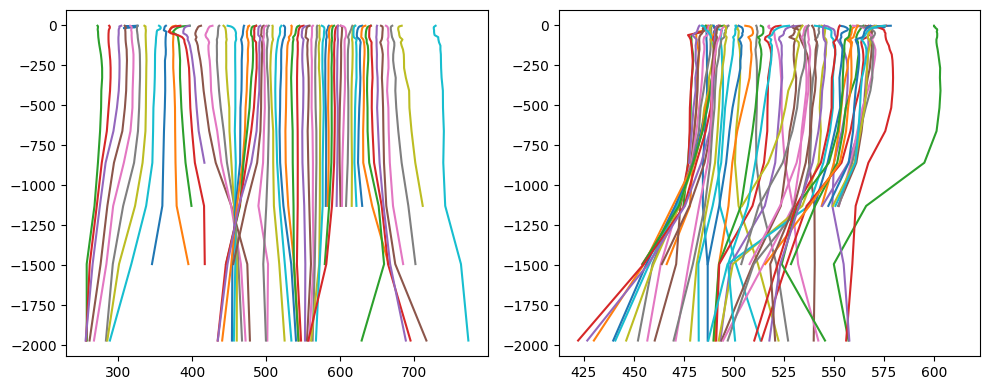

In [12]:
eddy = 382
dic = dic_sample[f'Eddy{eddy}']
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for day in dic.keys():
    df = dic[day].copy()
    df = df[df['Depth'] >= -2000]
    axs[0].plot(df['x'], df['Depth'])
    axs[1].plot(df['y'], df['Depth'])
plt.tight_layout()
    

In [ ]:
break

### Delta Method

In [13]:
sample_eddies

[2749, 8, 2504, 896, 1394, 382, 1967, 926]

In [92]:
import numpy as np
import pandas as pd

eddy   = 8
dic    = dic_sample[f'Eddy{eddy}']
num    = 8
depth_int = 10
max_depth = 1000

diffs_x = {}
diffs_y = {}

for d, day in enumerate(dic.keys()):
    if d >= num:
        break

    df = dic[day].copy()
    df['Depth'] = -df['Depth']
    df = df[df['Depth'] <= max_depth]
    # don’t drop rows — keep all depths, even if x or y are NaN
    df = df.set_index('Depth').sort_index()

    depths       = df.index.values
    # interpolate at every 10 m from 0 to max_depth
    target_depths = np.arange(0, max_depth+1, depth_int)
    valid = target_depths[
        (target_depths >= depths.min()) &
        (target_depths <= depths.max())
    ]
    if len(valid) < 2:
        continue

    x_i = np.interp(valid, depths, df['x'].values)
    y_i = np.interp(valid, depths, df['y'].values)

    dx = np.diff(x_i)
    dy = np.diff(y_i)

    delta = np.hypot(dx, dy)

    # use the actual depth levels (valid[:-1]) as the Series index
    idx = valid[:-1]

    diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
    diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)

# now construct your DataFrames simply by passing the dict-of-series:
df_X = pd.DataFrame(diffs_x)
df_Y = pd.DataFrame(diffs_y)

# each df_X, df_Y will be indexed by the **union** of all depth-levels,
# with NaNs where a particular day didn’t have that depth.
df_X


,$t_{0}$,$t_{1}$,$t_{2}$,$t_{3}$,$t_{4}$,$t_{5}$,$t_{6}$,$t_{7}$
10,-0.840735,-0.367667,0.551057,-1.533649,1.140657,-0.821091,1.359604,0.781972
20,0.959572,0.330551,0.639500,-1.629964,-0.380991,-0.175243,2.502692,0.663217
30,2.933629,0.997133,-0.264428,-0.139964,-0.671661,-0.438691,2.496476,0.682593
40,1.293718,0.368873,-0.386111,0.128967,-0.788902,-0.704685,0.203914,0.901790
50,0.053931,-0.785330,-0.068554,2.222622,0.204992,-0.470692,-0.526789,-0.319304
...,...,...,...,...,...,...,...,...
800,0.118188,0.279145,0.342366,0.260017,0.181393,0.139434,0.229996,0.255616
810,0.118188,0.279145,0.342366,0.260017,0.181393,0.139434,0.229996,0.255616
820,0.118188,0.279145,0.342366,0.260017,0.181393,0.139434,0.229996,0.255616
830,0.118188,0.279145,0.342366,0.260017,0.181393,0.139434,0.229996,0.255616


In [93]:
df_data = pd.DataFrame()
df_data[r'$\bar{x}$'] = df_X.mean(axis=1)
df_data[r'$\bar{y}$'] = df_Y.mean(axis=1)
# df_data[r'$\bar{Delta}$'] = df_delta.mean(axis=1)
df_data[r'$\sum{x}$'] = df_data[r'$\bar{x}$'].cumsum()
df_data[r'$\sum{y}$'] = df_data[r'$\bar{y}$'].cumsum()
# df_data[r'$\sum{Delta}$'] = df_data[r'$\bar{Delta}$'].cumsum()
df_data[r'$\sigma^2_x$'] = df_X.std(axis=1)
df_data[r'$\sigma^2_y$'] = df_Y.std(axis=1)
df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_x$'] + df_data[r'$\sigma^2_y$']
df_data['Depth'] = df_data.index 
df_data


,$\bar{x}$,$\bar{y}$,$\sum{x}$,$\sum{y}$,$\sigma^2_x$,$\sigma^2_y$,Total $\sigma^2$,Depth
10,0.033769,-0.716013,0.033769,-0.716013,1.063950,1.152333,2.216283,10
20,0.363667,-0.608372,0.397435,-1.324385,1.190255,1.243009,2.433264,20
30,0.699386,-0.384732,1.096821,-1.709117,1.368980,1.429218,2.798198,30
40,0.127195,0.170739,1.224017,-1.538377,0.738707,0.890893,1.629599,40
50,0.038859,0.258796,1.262876,-1.279581,0.940771,0.966583,1.907354,50
...,...,...,...,...,...,...,...,...
800,0.225769,-0.183811,12.322944,-7.759460,0.075140,0.155710,0.230850,800
810,0.225769,-0.183811,12.548714,-7.943271,0.075140,0.155710,0.230850,810
820,0.225769,-0.183811,12.774483,-8.127082,0.075140,0.155710,0.230850,820
830,0.225769,-0.183811,13.000253,-8.310892,0.075140,0.155710,0.230850,830


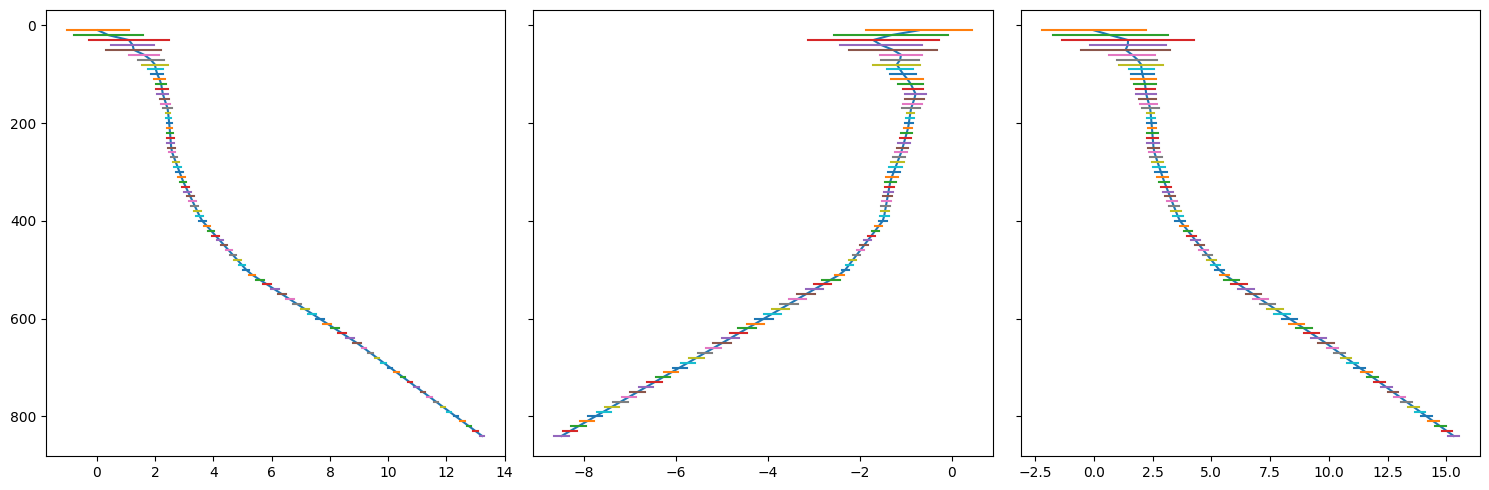

In [94]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
axs[0].plot(df_data[r'$\sum{x}$'], df_data['Depth'])
for k in range(len(df_data)):
    axs[0].plot([df_data.iloc[k][r'$\sum{x}$']-df_data.iloc[k][r'$\sigma^2_x$'],
                 df_data.iloc[k][r'$\sum{x}$']+df_data.iloc[k][r'$\sigma^2_x$']], [df_data.iloc[k]['Depth'], df_data.iloc[k]['Depth']])
axs[0].invert_yaxis()
axs[1].plot(df_data[r'$\sum{y}$'], df_data['Depth'])
for k in range(len(df_data)):
    axs[1].plot([df_data.iloc[k][r'$\sum{y}$']-df_data.iloc[k][r'$\sigma^2_y$'],
                 df_data.iloc[k][r'$\sum{y}$']+df_data.iloc[k][r'$\sigma^2_y$']], [df_data.iloc[k]['Depth'], df_data.iloc[k]['Depth']])
# axs[1].invert_yaxis()
TD = np.hypot(df_data[r'$\sum{x}$'] - df_data.iloc[0][r'$\sum{x}$'], df_data[r'$\sum{y}$'] - df_data.iloc[0][r'$\sum{y}$'])
axs[2].plot(TD, df_data['Depth'])

for k in range(len(df_data)):
    
    axs[2].plot([TD.iloc[k]-df_data.iloc[k][r'Total $\sigma^2$'],
                 TD.iloc[k]+df_data.iloc[k][r'Total $\sigma^2$']], [df_data.iloc[k]['Depth'], df_data.iloc[k]['Depth']])
# axs[1].invert_yaxis()
plt.tight_layout()


### RBT (Rigid Body Transformation) Approach

$$
\huge x' = x\cos\theta - y\sin\theta + a
$$
$$
\huge y' = x\sin\theta + y\cos\theta + b
$$
\
$$
\begin{aligned}
\huge R(a, b, \theta) & \huge = \sum_i \left[x_i'(t_1) - x_i(t_2)\right]^2 + \left[y_i'(t_1) - y_i(t_2)\right]^2 \\
                      & \huge = \sum_i \left[x_i(t_1)\cos\theta - y_i(t_1)\sin\theta + a - x_i(t_2) \right]^2 + \left[x_i(t_1)\sin\theta + y_i(t_1)\cos\theta + b - y_i(t_2)\right]^2
\end{aligned}
$$

In [32]:
def rotate_y_xy(points, theta_deg):
    """Rotate points (x, y) about the y-axis by angle theta (in degrees)."""
    theta = np.deg2rad(theta_deg) 
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    xy_rotated = np.dot(points[:, :2], rotation_matrix.T)
    return np.hstack((xy_rotated, points[:, 2:]))


In [83]:
sample_eddies

[2749, 8, 2504, 896, 1394, 382, 1967, 926]

In [84]:
import numpy as np
import pandas as pd

eddy      = 2749
dic       = dic_sample[f'Eddy{eddy}']
t0, t_r   = 30, 3
days      = list(dic.keys())[t0 - t_r : t0 + t_r + 1]

depth_int = 10
max_depth = 1000
# global target grid
target_depths = np.arange(depth_int, max_depth+1, depth_int)

interp_dfs = []
for day in days:
    df = dic[day].copy()
    df['Depth'] = -df['Depth']
    df = df[df['Depth'] <= max_depth]
    df = df.set_index('Depth').sort_index()

    depths = df.index.values
    # interp with NaN outside (left/right)
    x_i = np.interp(target_depths, depths, df['x'].values,
                    left=np.nan, right=np.nan)
    y_i = np.interp(target_depths, depths, df['y'].values,
                    left=np.nan, right=np.nan)

    interp_dfs.append(
        pd.DataFrame({
            'Day': int(day[3:]),
            'Depth': target_depths,
            'x':     x_i,
            'y':     y_i
        })
    )

df_int = pd.concat(interp_dfs, ignore_index=True)
df_int = df_int.dropna()
# df_int
df_int.head()


,Day,Depth,x,y
0,9962,10,297.690093,337.486843
1,9962,20,315.253919,319.058810
2,9962,30,315.159631,322.693699
3,9962,40,316.025592,323.341435
4,9962,50,316.191202,325.216308


In [66]:
# eddy = 382
# max_depth = 1000

# dic = dic_sample[f'Eddy{eddy}']
# t0, t_r = 30, 5
# days = list(dic.keys())[t0 - t_r : t0 + t_r + 1]

# df_int = pd.concat([dic[day].assign(Day=int(day[3:])) for day in days], ignore_index=True)
# df_int['Depth'] = -df_int['Depth']
# df_int = df_int[df_int['Depth'] <= max_depth]
# df_int.head()


,x,y,Q,w,Rc,psi0,z,Depth,TD,Grad,Day
0,496.449781,492.947153,"[[-0.004675291499241154, 0.0014689567964859208...",-0.029491,4.854977,23.743623,0,1.783320,0.000000,NaN,2699
1,494.851022,492.383233,"[[-0.004571811044739067, 0.0014726278749682556...",-0.029511,5.150530,26.633813,1,5.879627,1.695298,0.352724,2699
2,494.229258,491.894061,"[[-0.004570111764368265, 0.001391528653611605]...",-0.030370,5.293940,27.932421,2,10.725783,2.457585,0.786748,2699
3,493.825119,491.673035,"[[-0.004567540689604781, 0.0013935061028588107...",-0.030402,5.241988,27.411050,3,16.383097,2.917572,0.546906,2699
4,493.548770,491.490057,"[[-0.00456787447278143, 0.0014033367496249104]...",-0.030436,5.206852,27.055369,4,22.925581,3.246382,0.662129,2699


In [85]:
from scipy.interpolate import interp1d
from scipy.optimize import minimize

def cost(p, x_t, y_t, x_ref, y_ref):
    dx, dy, θ = p
    c, s = np.cos(θ), np.sin(θ)
    tx =  x_t * c - y_t * s + dx
    ty =  x_t * s + y_t * c + dy
    return np.sum((tx - x_ref)**2 + (ty - y_ref)**2)

def rmse(p, x_t, y_t, x_ref, y_ref):
    return np.sqrt(cost(p, x_t, y_t, x_ref, y_ref) / len(x_ref))

def resample_coords(x, y, n):
    # cumulative distance along the curve
    d = np.hypot(np.diff(x), np.diff(y))
    s = np.concatenate([[0], np.cumsum(d)])
    fx = interp1d(s, x, kind='linear')
    fy = interp1d(s, y, kind='linear')
    s_new = np.linspace(0, s[-1], n)
    x2, y2 = fx(s_new), fy(s_new)
    return x2 - x2[0], y2 - y2[0]

days = df_int['Day'].unique()
mid_day = days[len(days)//2]
ref = df_int[df_int['Day'] == mid_day]
n_ref = len(ref)
x_ref, y_ref = resample_coords(ref.x.values, ref.y.values, n_ref)

results = []
for day in days:
    df_day = df_int[df_int['Day'] == day]
    x_t, y_t = resample_coords(df_day.x.values, df_day.y.values, n_ref)

    res = minimize(
        lambda p: cost(p, x_t, y_t, x_ref, y_ref),
        [0, 0, 0],
        bounds=[(None, None), (None, None), (0, 2*np.pi)]
    )
    if res.success:
        dx, dy, θ = res.x
        results.append({
            'Day':    day,
            'x_delta': dx,
            'y_delta': dy,
            'theta':   np.rad2deg(θ),
            'rmse':    rmse(res.x, x_t, y_t, x_ref, y_ref)
        })

df_best_shift = pd.DataFrame(results)
df_best_shift

,Day,x_delta,y_delta,theta,rmse
0,9962,9.670955,-17.376834,0.000000,26.125168
1,9963,5.025773,-1.710438,33.015620,3.740622
2,9964,2.233772,-1.278024,15.302568,2.190252
3,9965,0.000000,0.000000,0.000000,0.000000
4,9966,-2.638505,-2.634086,0.000000,2.829681
5,9967,0.387857,-3.062081,0.000000,5.460251
6,9968,10.153880,-7.072456,0.000000,11.025624


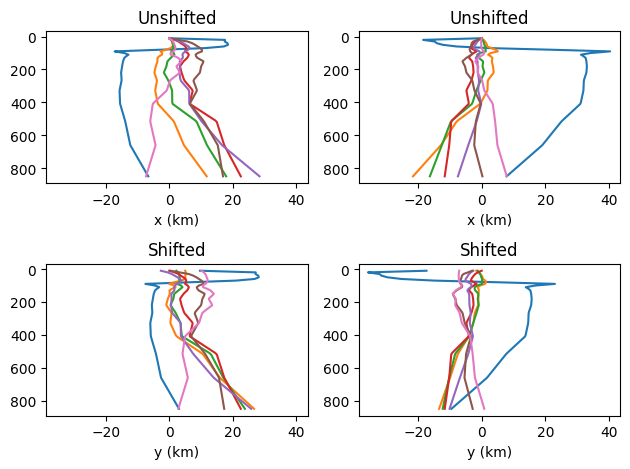

In [86]:
fig, axs = plt.subplots(2, 2)
df_shifted = df_int.copy()
for day in df_int['Day'].unique():
    df = df_int[df_int['Day']==day]
    i_surf = df['Depth'].abs().argmin()
    x, y = df['x']-df.iloc[i_surf]['x'], df['y']-df.iloc[i_surf]['y']
    x, y = x.values, y.values
    axs[0,0].plot(x, df['Depth'])
    axs[0,1].plot(y, df['Depth'])
    axs[0,0].set_title('Unshifted')
    axs[0,1].set_title('Unshifted')
    data = df_best_shift[df_best_shift['Day']==day]
    x_delta, y_delta = data.iloc[0]['x_delta'], data.iloc[0]['y_delta']
    theta = data.iloc[0]['theta']

    points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
    x_shifted = points_rotated[:, 0] + x_delta
    y_shifted = points_rotated[:, 1] + y_delta

    df_shifted.loc[df_shifted['Day']==day, 'x'] = x_shifted
    df_shifted.loc[df_shifted['Day']==day, 'y'] = y_shifted

    axs[1,0].plot(x_shifted, df['Depth'])
    axs[1,1].plot(y_shifted, df['Depth'])
    axs[1,0].set_title('Shifted')
    axs[1,1].set_title('Shifted')

axs[0,0].set_xlabel('x (km)')
axs[0,1].set_xlabel('x (km)')
axs[1,0].set_xlabel('y (km)')
axs[1,1].set_xlabel('y (km)')

xmin, xmax = 0, 0 
for ax in axs.flat:
    xmin = min(xmin, ax.get_xlim()[0])
    xmax = max(xmax, ax.get_xlim()[1])
for ax in axs.flat:
    ax.set_xlim(xmin, xmax)
    ax.invert_yaxis()
plt.tight_layout()
plt.show()


,Depth,Day,x,y,TD
0,850,9965.0,13.886115,-3.702838,14.371333
1,840,9965.0,13.592765,-3.583318,14.057148
2,830,9965.0,13.299415,-3.463797,13.743083
3,820,9965.0,13.006064,-3.344277,13.429144
4,810,9965.0,12.712714,-3.224756,13.115340


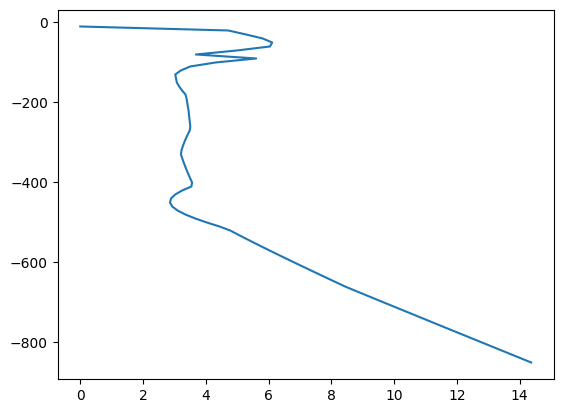

In [87]:
df_mean = df_shifted.groupby('Depth').mean()#.drop(columns=['Q', 'TD', 'Grad', 'Day'])
df_mean = df_mean.sort_index(ascending=False)
df_mean = df_mean.reset_index()
i_surf = df_mean['Depth'].abs().argmin()
df_mean['x'] = df_mean['x'] - df_mean.iloc[i_surf]['x']
df_mean['y'] = df_mean['y'] - df_mean.iloc[i_surf]['y']

df_mean['TD'] = np.hypot(df_mean['x'], df_mean['y'])
plt.plot(df_mean['TD'], -df_mean['Depth'])
df_mean.head()


## Delta and RBT combination

In [256]:
# Interpolate to depth bins

eddy   = 8
dic    = dic_sample[f'Eddy{eddy}']
num    = 6
depth_int = 10
max_depth = 1000

diffs_x = {}
diffs_y = {}

df_int = pd.DataFrame(columns=['Day', 'Depth', 'x', 'y'])

for d, day in enumerate(dic.keys()):
    if d >= num:
        break

    df = dic[day].copy()
    df['Depth'] = -df['Depth']
    df = df[df['Depth'] <= max_depth]
    # don’t drop rows — keep all depths, even if x or y are NaN
    df = df.set_index('Depth').sort_index()

    depths       = df.index.values
    # interpolate at every 10 m from 0 to max_depth
    target_depths = np.arange(0, max_depth+1, depth_int)
    valid = target_depths[
        (target_depths >= depths.min()) &
        (target_depths <= depths.max())
    ]
    if len(valid) < 2:
        continue

    x_i = np.interp(valid, depths, df['x'].values)
    y_i = np.interp(valid, depths, df['y'].values)

    dx = np.diff(x_i)
    dy = np.diff(y_i)

    delta = np.hypot(dx, dy)

    # use the actual depth levels (valid[:-1]) as the Series index
    idx = valid[:-1]

    diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
    diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)

    df = pd.DataFrame({'Day': day[3:], 'Depth': valid, 'x': x_i, 'y': y_i})

    if d == 0:
        df_int = df
    else:
        df_int = pd.concat([df_int, df], ignore_index=True)

# now construct your DataFrames simply by passing the dict-of-series:
df_X = pd.DataFrame(diffs_x)
df_Y = pd.DataFrame(diffs_y)

# each df_X, df_Y will be indexed by the **union** of all depth-levels,
# with NaNs where a particular day didn’t have that depth.
df_X


,$t_{0}$,$t_{1}$,$t_{2}$,$t_{3}$,$t_{4}$,$t_{5}$
10,-0.840735,-0.367667,0.551057,-1.533649,1.140657,-0.821091
20,0.959572,0.330551,0.639500,-1.629964,-0.380991,-0.175243
30,2.933629,0.997133,-0.264428,-0.139964,-0.671661,-0.438691
40,1.293718,0.368873,-0.386111,0.128967,-0.788902,-0.704685
50,0.053931,-0.785330,-0.068554,2.222622,0.204992,-0.470692
...,...,...,...,...,...,...
800,0.118188,0.279145,0.342366,0.260017,0.181393,0.139434
810,0.118188,0.279145,0.342366,0.260017,0.181393,0.139434
820,0.118188,0.279145,0.342366,0.260017,0.181393,0.139434
830,0.118188,0.279145,0.342366,0.260017,0.181393,0.139434


In [227]:
# Space Data
df_int

,Day,Depth,x,y
0,1462,10,351.920806,486.314737
1,1462,20,351.080071,485.304490
2,1462,30,352.039643,482.570253
3,1462,40,354.973272,479.205894
4,1462,50,356.266990,478.858501
...,...,...,...,...
505,1467,810,374.188533,469.424033
506,1467,820,374.327968,469.336439
507,1467,830,374.467402,469.248845
508,1467,840,374.606836,469.161250


In [228]:
# Calculation of variability at each depth
df_data = pd.DataFrame()
df_data[r'$\bar{x}$'] = df_X.mean(axis=1)
df_data[r'$\bar{y}$'] = df_Y.mean(axis=1)
df_data[r'$\sum{x}$'] = df_data[r'$\bar{x}$'].cumsum()
df_data[r'$\sum{y}$'] = df_data[r'$\bar{y}$'].cumsum()
df_data[r'$\sigma^2_x$'] = df_X.std(axis=1)
df_data[r'$\sigma^2_y$'] = df_Y.std(axis=1)
df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_x$'] + df_data[r'$\sigma^2_y$']
df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
df_data['Depth'] = df_data.index 
df_data


,$\bar{x}$,$\bar{y}$,$\sum{x}$,$\sum{y}$,$\sigma^2_x$,$\sigma^2_y$,Total $\sigma^2$,weight,Depth
10,-0.311905,-0.660437,-0.311905,-0.660437,0.988872,1.258006,2.246879,0.445062,10
20,-0.042763,-0.573812,-0.354667,-1.234249,0.923112,1.349159,2.272271,0.440088,20
30,0.402670,-0.556531,0.048002,-1.790780,1.368261,1.647341,3.015602,0.331609,30
40,-0.014690,-0.050613,0.033313,-1.841392,0.786529,0.930366,1.716895,0.582447,40
50,0.192828,0.102945,0.226141,-1.738447,1.058761,1.038788,2.097549,0.476747,50
...,...,...,...,...,...,...,...,...,...
800,0.220091,-0.212043,11.089141,-9.557524,0.087658,0.170880,0.258538,3.867905,800
810,0.220091,-0.212043,11.309231,-9.769567,0.087658,0.170880,0.258538,3.867905,810
820,0.220091,-0.212043,11.529322,-9.981610,0.087658,0.170880,0.258538,3.867905,820
830,0.220091,-0.212043,11.749413,-10.193654,0.087658,0.170880,0.258538,3.867905,830


In [229]:
# Caluclation of Weights from the volitility at each depth
df_int_weights = (
    df_int
    .merge(df_data[['Depth',r'Total $\sigma^2$']], on='Depth', how='left')
)
df_int_weights['weight'] = 1 / df_int_weights[r'Total $\sigma^2$']
df_int_weights = df_int_weights.dropna()
df_int_weights


,Day,Depth,x,y,Total $\sigma^2$,weight
0,1462,10,351.920806,486.314737,2.246879,0.445062
1,1462,20,351.080071,485.304490,2.272271,0.440088
2,1462,30,352.039643,482.570253,3.015602,0.331609
3,1462,40,354.973272,479.205894,1.716895,0.582447
4,1462,50,356.266990,478.858501,2.097549,0.476747
...,...,...,...,...,...,...
504,1467,800,374.049099,469.511627,0.258538,3.867905
505,1467,810,374.188533,469.424033,0.258538,3.867905
506,1467,820,374.327968,469.336439,0.258538,3.867905
507,1467,830,374.467402,469.248845,0.258538,3.867905


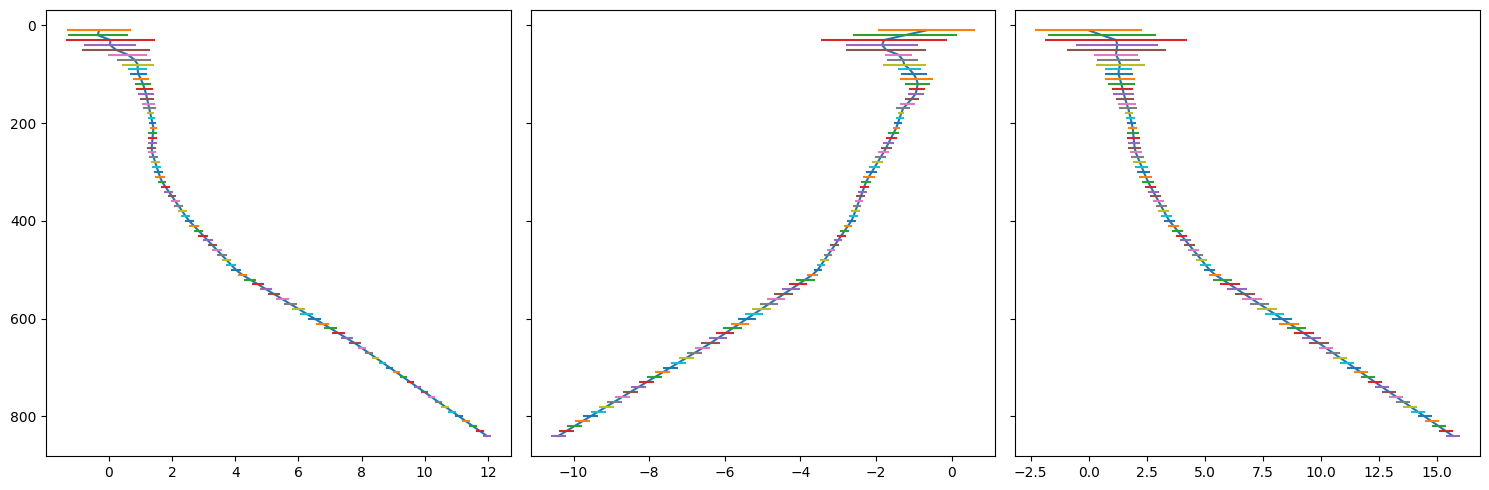

In [204]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
axs[0].plot(df_data[r'$\sum{x}$'], df_data['Depth'])
for k in range(len(df_data)):
    axs[0].plot([df_data.iloc[k][r'$\sum{x}$']-df_data.iloc[k][r'$\sigma^2_x$'],
                 df_data.iloc[k][r'$\sum{x}$']+df_data.iloc[k][r'$\sigma^2_x$']], [df_data.iloc[k]['Depth'], df_data.iloc[k]['Depth']])
axs[0].invert_yaxis()
axs[1].plot(df_data[r'$\sum{y}$'], df_data['Depth'])
for k in range(len(df_data)):
    axs[1].plot([df_data.iloc[k][r'$\sum{y}$']-df_data.iloc[k][r'$\sigma^2_y$'],
                 df_data.iloc[k][r'$\sum{y}$']+df_data.iloc[k][r'$\sigma^2_y$']], [df_data.iloc[k]['Depth'], df_data.iloc[k]['Depth']])
# axs[1].invert_yaxis()
TD = np.hypot(df_data[r'$\sum{x}$'] - df_data.iloc[0][r'$\sum{x}$'], df_data[r'$\sum{y}$'] - df_data.iloc[0][r'$\sum{y}$'])
axs[2].plot(TD, df_data['Depth'])

for k in range(len(df_data)):
    
    axs[2].plot([TD.iloc[k]-df_data.iloc[k][r'Total $\sigma^2$'],
                 TD.iloc[k]+df_data.iloc[k][r'Total $\sigma^2$']], [df_data.iloc[k]['Depth'], df_data.iloc[k]['Depth']])
# axs[1].invert_yaxis()
plt.tight_layout()


In [230]:
df_data


,$\bar{x}$,$\bar{y}$,$\sum{x}$,$\sum{y}$,$\sigma^2_x$,$\sigma^2_y$,Total $\sigma^2$,weight,Depth
10,-0.311905,-0.660437,-0.311905,-0.660437,0.988872,1.258006,2.246879,0.445062,10
20,-0.042763,-0.573812,-0.354667,-1.234249,0.923112,1.349159,2.272271,0.440088,20
30,0.402670,-0.556531,0.048002,-1.790780,1.368261,1.647341,3.015602,0.331609,30
40,-0.014690,-0.050613,0.033313,-1.841392,0.786529,0.930366,1.716895,0.582447,40
50,0.192828,0.102945,0.226141,-1.738447,1.058761,1.038788,2.097549,0.476747,50
...,...,...,...,...,...,...,...,...,...
800,0.220091,-0.212043,11.089141,-9.557524,0.087658,0.170880,0.258538,3.867905,800
810,0.220091,-0.212043,11.309231,-9.769567,0.087658,0.170880,0.258538,3.867905,810
820,0.220091,-0.212043,11.529322,-9.981610,0.087658,0.170880,0.258538,3.867905,820
830,0.220091,-0.212043,11.749413,-10.193654,0.087658,0.170880,0.258538,3.867905,830


In [251]:
import numpy as np

# your data arrays of shape (N,)
x = df_data[r'$\sum{x}$'].values
y = df_data[r'$\sum{y}$'].values
z = df_data['Depth'].values
w = df_data['weight'].values

# 1. compute weighted mean
W = np.sum(w)
mean = np.array([np.dot(w, x),
                 np.dot(w, y),
                 np.dot(w, z)]) / W

# 2. center and weight the data
X = np.vstack((x, y, z)).T
Xc = X - mean
Xw = Xc * np.sqrt(w)[:, None]

# 3. SVD on weighted, centered data
_, _, Vt = np.linalg.svd(Xw, full_matrices=False)
direction = Vt[0]   # principal axis

# The best-fit line is:  p(t) = mean + t * direction
t = np.linspace((np.max(z)-mean[2])/direction[2], (np.min(z)-mean[2])/direction[2], 100)            # shape (100,)
p = mean[None, :] + t[:, None] * direction  # shape (100,3)
# or equivalently
p = mean + np.outer(t, direction)          # also (100,3)

# then split back out if you need x,y,z separately:
x_line, y_line, z_line = p.T



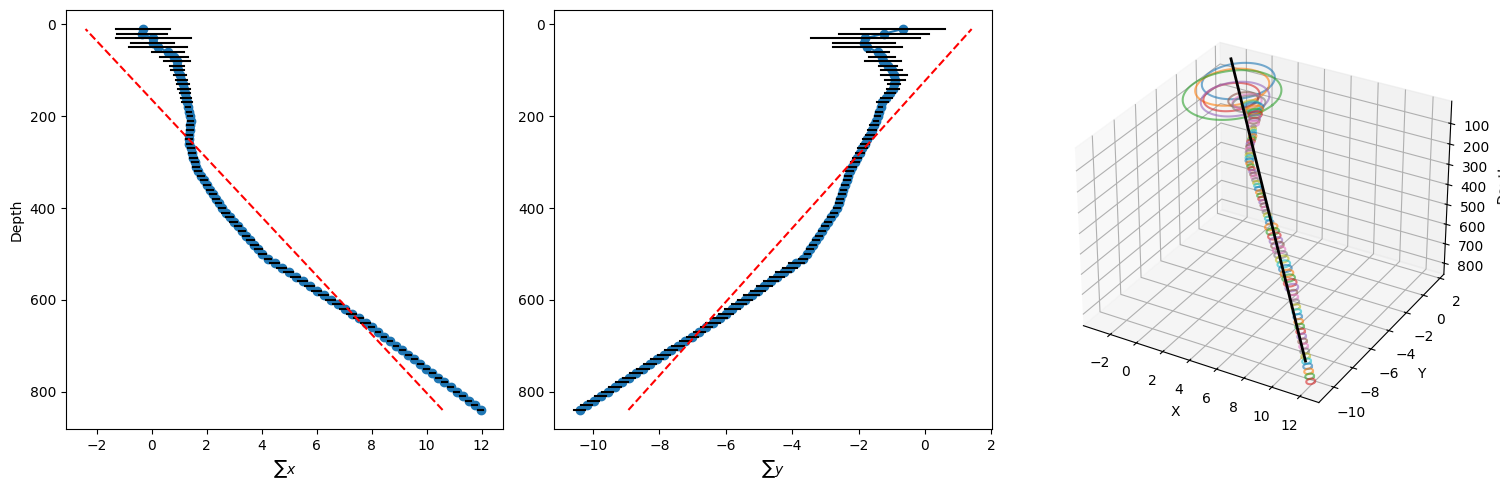

In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection

# — your data —
# assume df_data has columns: '$\\sum{x}$', '$\\sum{y}$', 'Depth', 'Total $\\sigma^2$'
# and that x_line, y_line, z_line are your best‐fit line coordinates

# example placeholders:
# df_data = pd.DataFrame({...})
# x_line, y_line, z_line = ...

# set up figure with first two 2D and last one 3D
fig = plt.figure(figsize=(15, 5))

ax0 = fig.add_subplot(1, 3, 1)
ax1 = fig.add_subplot(1, 3, 2, sharey=ax0)
ax2 = fig.add_subplot(1, 3, 3, projection='3d')

# — panel 1: sum{x} vs depth with error‐bars and line —
ax0.plot(df_data[r'$\sum{x}$'], df_data['Depth'], 'o-')
for k, depth in enumerate(df_data['Depth']):
    x0 = df_data.iloc[k][r'$\sum{x}$']
    r = df_data.iloc[k][r'$\sigma^2_x$']
    ax0.plot([x0 - r, x0 + r], [depth, depth], 'k-')
ax0.invert_yaxis()
ax0.plot(x_line, z_line, 'r--')
ax0.set_xlabel(r'$\sum x$')
ax0.set_ylabel('Depth')

# — panel 2: sum{y} vs depth —
ax1.plot(df_data[r'$\sum{y}$'], df_data['Depth'], 'o-')
for k, depth in enumerate(df_data['Depth']):
    y0 = df_data.iloc[k][r'$\sum{y}$']
    r = df_data.iloc[k][r'$\sigma^2_y$']
    ax1.plot([y0 - r, y0 + r], [depth, depth], 'k-')
ax1.plot(y_line, z_line, 'r--')
ax1.set_xlabel(r'$\sum y$')

# — panel 3: 3D circles + best‐fit line —
theta = np.linspace(0, 2*np.pi, 100)
for x0, y0, depth, r in zip(
        df_data[r'$\sum{x}$'],
        df_data[r'$\sum{y}$'],
        df_data['Depth'],
        df_data[r'Total $\sigma^2$']
    ):
    xs = x0 + r * np.cos(theta)
    ys = y0 + r * np.sin(theta)
    zs = np.full_like(theta, depth)
    ax2.plot(xs, ys, zs, alpha=0.6)

# plot best‐fit line in 3D
ax2.plot(x_line, y_line, z_line, 'k-', linewidth=2)

# invert the depth‐axis (z) so that increasing depth goes downwards
ax2.set_zlim(ax2.get_zlim()[::-1])

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Depth')

plt.tight_layout()
plt.show()


In [221]:
## RBT part
from scipy.optimize import minimize

# 1. pick your reference day and sort by depth
days    = df_int_weights['Day'].unique()
mid_day = days[len(days)//2]
ref     = df_int_weights[df_int_weights['Day'] == mid_day].sort_values('Depth')

# 2. pull out x_ref, y_ref *and* w_ref in depth‐order
n_ref   = len(ref)
x_ref, y_ref = resample_coords(ref.x.values, ref.y.values, n_ref)
w_ref         = ref['weight'].values    # shape (n_ref,)

# 3. define a weighted‐MSE cost
def weighted_cost(p, x_t, y_t, x_ref, y_ref, w):
    dx, dy, θ = p
    c, s = np.cos(θ), np.sin(θ)
    x_s = dx +  c*x_t - s*y_t
    y_s = dy +  s*x_t + c*y_t
    err2 = (x_s - x_ref)**2 + (y_s - y_ref)**2
    return np.sum(w * err2) / np.sum(w)

# 4. loop through days, resample x,y, minimise, compute weighted‐RMSE
results = []
for day in days:
    df_day = df_int_weights[df_int_weights['Day'] == day].sort_values('Depth')
    x_t, y_t = resample_coords(df_day.x.values, df_day.y.values, n_ref)

    res = minimize(
        lambda p: weighted_cost(p, x_t, y_t, x_ref, y_ref, w_ref),
        x0=[0,0,0],
        bounds=[(None,None),(None,None),(0,2*np.pi)]
    )
    if not res.success:
        continue

    dx, dy, θ = res.x
    # compute weighted RMSE
    c, s = np.cos(θ), np.sin(θ)
    x_s = dx +  c*x_t - s*y_t
    y_s = dy +  s*x_t + c*y_t
    err2 = (x_s - x_ref)**2 + (y_s - y_ref)**2
    rmse_w = np.sqrt(np.sum(w_ref * err2) / np.sum(w_ref))

    results.append({
        'Day':     day,
        'x_delta': dx,
        'y_delta': dy,
        'theta':   np.rad2deg(θ),
        'rmse':    rmse_w
    })

df_best_shift = pd.DataFrame(results)
df_best_shift


,Day,x_delta,y_delta,theta,rmse
0,1462,-8.453656,0.762351,6.498033,4.186744
1,1463,-2.970826,-7.374740,0.523986,2.707226
2,1464,-2.148174,-10.165345,0.000000,2.678860
3,1465,0.000000,0.000000,0.000000,0.000000
4,1466,-2.436417,-9.006543,0.000000,2.847288
5,1467,1.056803,-5.367904,0.000000,2.889022


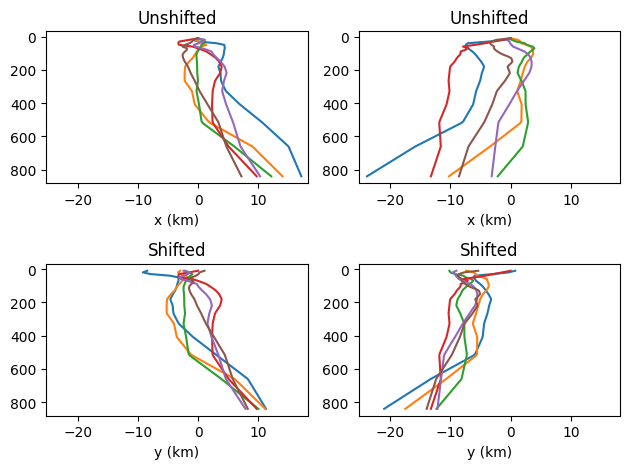

In [197]:
fig, axs = plt.subplots(2, 2)
df_shifted = df_int.copy()
for day in df_int['Day'].unique():
    df = df_int[df_int['Day']==day]
    i_surf = df['Depth'].abs().argmin()
    x, y = df['x']-df.iloc[i_surf]['x'], df['y']-df.iloc[i_surf]['y']
    x, y = x.values, y.values
    axs[0,0].plot(x, df['Depth'])
    axs[0,1].plot(y, df['Depth'])
    axs[0,0].set_title('Unshifted')
    axs[0,1].set_title('Unshifted')
    data = df_best_shift[df_best_shift['Day']==day]
    x_delta, y_delta = data.iloc[0]['x_delta'], data.iloc[0]['y_delta']
    theta = data.iloc[0]['theta']

    points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
    x_shifted = points_rotated[:, 0] + x_delta
    y_shifted = points_rotated[:, 1] + y_delta

    df_shifted.loc[df_shifted['Day']==day, 'x'] = x_shifted
    df_shifted.loc[df_shifted['Day']==day, 'y'] = y_shifted

    axs[1,0].plot(x_shifted, df['Depth'])
    axs[1,1].plot(y_shifted, df['Depth'])
    axs[1,0].set_title('Shifted')
    axs[1,1].set_title('Shifted')

axs[0,0].set_xlabel('x (km)')
axs[0,1].set_xlabel('x (km)')
axs[1,0].set_xlabel('y (km)')
axs[1,1].set_xlabel('y (km)')

xmin, xmax = 0, 0 
for ax in axs.flat:
    xmin = min(xmin, ax.get_xlim()[0])
    xmax = max(xmax, ax.get_xlim()[1])
for ax in axs.flat:
    ax.set_xlim(xmin, xmax)
    ax.invert_yaxis()
plt.tight_layout()
plt.show()


,Depth,x,y,TD
0,840,12.196351,-9.823501,15.660528
1,830,11.967372,-9.614594,15.351169
2,820,11.738393,-9.405687,15.041836
3,810,11.509415,-9.196780,14.732528
4,800,11.280436,-8.987873,14.423248


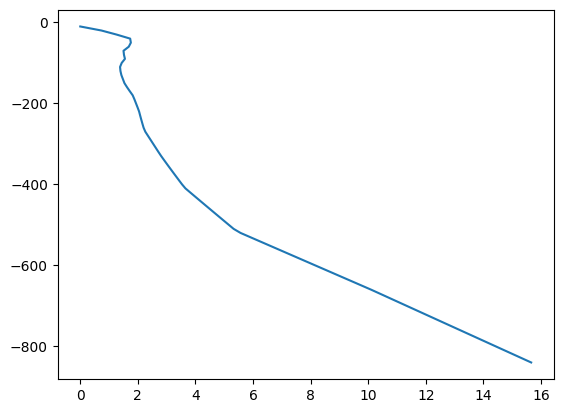

In [200]:
df_mean = df_shifted.drop(columns=[r'Total $\sigma^2$', 'weight', 'Day']).groupby('Depth').mean()
df_mean = df_mean.sort_index(ascending=False)
df_mean = df_mean.reset_index()
i_surf = df_mean['Depth'].abs().argmin()
df_mean['x'] = df_mean['x'] - df_mean.iloc[i_surf]['x']
df_mean['y'] = df_mean['y'] - df_mean.iloc[i_surf]['y']

df_mean['TD'] = np.hypot(df_mean['x'], df_mean['y'])
plt.plot(df_mean['TD'], -df_mean['Depth'])
df_mean.head()
